<img src="img/fib.png" alt="SVDS" width="300" align="left">

# *James Doone* 
## Applied Time Series Econometrics in Python

Thanks to Jeffrey Yau and his team of data scientists.


### 1.1 Model selection heuristics

ARIMA $(p,d,q)$

SARIMAX $(p,d,q) \times (P,D,Q)_{s}$

- Examine the time series to understand its characteristics, e.g., trend, seasonality.
- Choose an appropriate model form (ARIMA, SARIMA, ARIMAX, SARIMAX).
- Check for (unit root) stationarity of the time series.
  - Determine whether differencing (informs $d$ and $D$) or other transformation is necessary to make stationary.
- Examine ACF and PACF to determine the initial choice of the AR($p$) and MA($q$) model orders, and seasonal $P$ and $Q$ orders if appropriate.
- Alternatively, or in addition, fit many models.
- Choose a model based on:
  - A criterion, e.g., AIC, BIC
  - Examination of statistical tests on residuals.
  - Out-of-sample forecast error.

<div class = "alert alert-danger">
$Load$ $Libraries$
</div>

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format='retina'

from __future__ import absolute_import, division, print_function

import sys
import os

import pandas as pd
import numpy as np

import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt

import itertools
import warnings

# Display and Plotting
import matplotlib.pylab as plt
import seaborn as sns

pd.set_option('display.float_format', lambda x: '%.5f' % x) # pandas
np.set_printoptions(precision=5, suppress=True) # numpy

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

# seaborn plotting style
sns.set(style='ticks', context='poster')

/Users/jimdoone/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


<div class = "alert alert-info">
$Load$ $and$ $Evaluate$ $Data$
</div>

In [2]:
df = pd.read_excel("Datasets_Udemy/Wallmart.xls", index_col=0)
df.head(1)

Ridership ('000)  Lag 1  detrend  lag 12  deseasonalize  \
Month                                                                 
1991-01-01        1708.91700    nan      nan     nan            nan   

            lag(deseasonalize)  detrend, deseasonalize  
Month                                                   
1991-01-01                 nan                     nan

In [3]:
ts = df.iloc[:-1, 0:1]

In [4]:
#ts['Month'] = ts['Month'].dt.strftime("%Y-%b")
ts.head(1)

Ridership ('000)
Month                       
1991-01-01        1708.91700

In [5]:
#ts.set_index('Month', drop=True, inplace=True)

In [6]:
# Examine the basic structure of the data
print("Data shape:", ts.shape, "\n")
print("First 5 observations of the data series:", "\n", ts.head())
print("Last 5 observations of the data series:", "\n", ts.tail())

Data shape: (159, 1) 

First 5 observations of the data series: 
             Ridership ('000)
Month                       
1991-01-01        1708.91700
1991-02-01        1620.58600
1991-03-01        1972.71500
1991-04-01        1811.66500
1991-05-01        1974.96400
Last 5 observations of the data series: 
             Ridership ('000)
Month                       
2003-11-01        2076.05400
2003-12-01        2140.67700
2004-01-01        1831.50800
2004-02-01        1838.00600
2004-03-01        2132.44600


<div class = "alert alert-info">
$Training$ $and$ $Test$ $Set$
</div>

In [7]:
n_sample = ts.shape[0]

# Create a training sample and testing sample before analyzing the series

n_train=int(0.95*n_sample)+1
n_forecast=n_sample-n_train
#ts_df
ts_train = ts.iloc[:n_train]#['value']
ts_test = ts.iloc[n_train:]#['value']
print(ts_train.shape)
print(ts_test.shape)
print("Training Series:", "\n", ts_train.tail(), "\n")
print("Testing Series:", "\n", ts_test.head())


(152, 1)
(7, 1)
Training Series: 
             Ridership ('000)
Month                       
2003-04-01        2098.89900
2003-05-01        2104.91100
2003-06-01        2129.67100
2003-07-01        2223.34900
2003-08-01        2174.36000 

Testing Series: 
             Ridership ('000)
Month                       
2003-09-01        1931.40600
2003-10-01        2121.47000
2003-11-01        2076.05400
2003-12-01        2140.67700
2004-01-01        1831.50800


<div class = "alert alert-info">
$Timeseries$ $Plot$
</div>

In [8]:
def tsplot(y, lags=None, title='', figsize=(14, 8)):
    '''Examine the patterns of ACF and PACF, along with the time series plot and histogram.
    
    Original source: https://tomaugspurger.github.io/modern-7-timeseries.html
    '''
    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax   = plt.subplot2grid(layout, (0, 0))
    hist_ax = plt.subplot2grid(layout, (0, 1))
    acf_ax  = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))
    
    y.plot(ax=ts_ax)
    ts_ax.set_title(title)
    y.plot(ax=hist_ax, kind='hist', bins=25)
    hist_ax.set_title('Histogram')
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
    [ax.set_xlim(0) for ax in [acf_ax, pacf_ax]]
    sns.despine()
    fig.tight_layout()
    return ts_ax, acf_ax, pacf_ax

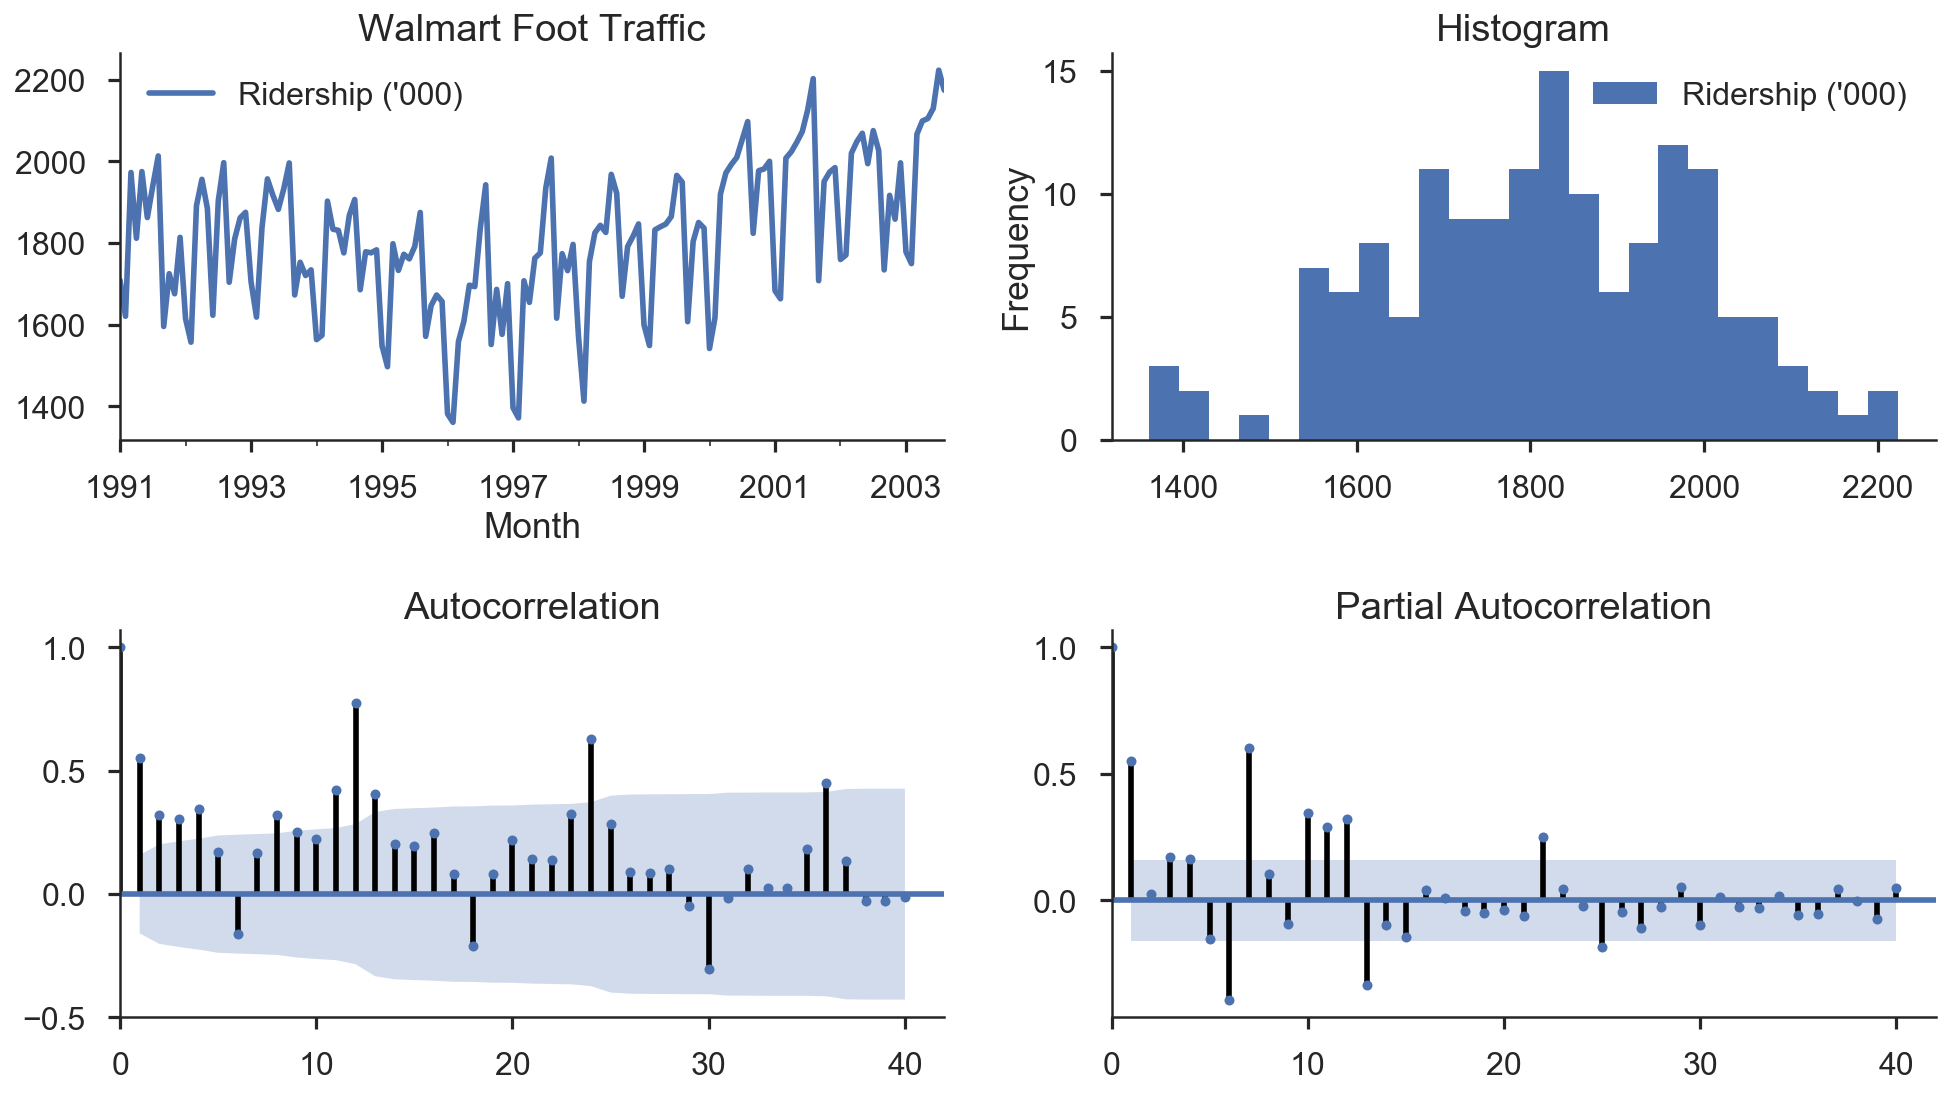

In [9]:
tsplot(ts_train, lags=40, title='Walmart Foot Traffic', figsize=(14, 8));

  <div class ="alert alert-info">
$ACF$, $PACF$, $Time$ $Series$ $Plot$, $Histogram$
</div>
  
  **Patterns of the ACF and PACF associated with the $AR(p)$, $MA(q)$, and $ARMA(p,q)$ processes:**



|  Process      |          ACF         |          PACF        |
|---------------|:--------------------:|:--------------------:|
| **AR(p)**     |    tails off         | cutoff after lag $p$ |
| **MA(q)**     | cutoff after lag $q$ |    tails off         |
| **ARMA(p,q)** |    tails off         |    tails off         |


1. The data may follow an ARIMA$(p,d,0)$ model if the ACF and PACF plots of the differenced data show the following patterns:

    - the ACF is exponentially decaying or sinusoidal;
    - there is a significant spike at lag pp in PACF, but none beyond lag pp.
    
2. The data may follow an ARIMA$(0,d,q)$ model if the ACF and PACF plots of the differenced data show the following patterns:

    - the PACF is exponentially decaying or sinusoidal;
    - there is a significant spike at lag $q$ in ACF, but none beyond lag $q$.


<div class="alert alert-info">
$Augmented$  $Dickey-Fuller$ $ (ADF) $
</div>

In [10]:
def test_stationarity(timeseries,
                      maxlag=None, regression=None, autolag=None,
                      window=None, plot=False, verbose=False):
    '''
    Check unit root stationarity of time series.
    
    Null hypothesis: the series is non-stationary.
    If p >= alpha, the series is non-stationary.
    If p < alpha, reject the null hypothesis (has unit root stationarity).
    
    Original source: http://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/
    
    Function: http://statsmodels.sourceforge.net/devel/generated/statsmodels.tsa.stattools.adfuller.html
    
    window argument is only required for plotting rolling functions. Default=4.
    '''
    
    # set defaults (from function page)
    if regression is None:
        regression = 'c'
    
    if verbose:
        print('Running Augmented Dickey-Fuller test with paramters:')
        print('maxlag: {}'.format(maxlag))
        print('regression: {}'.format(regression))
        print('autolag: {}'.format(autolag))
    
    if plot:
        if window is None:
            window = 4
        #Determing rolling statistics
        rolmean = timeseries.rolling(window=window, center=False).mean()
        rolstd = timeseries.rolling(window=window, center=False).std()
        
        #Plot rolling statistics:
        orig = plt.plot(timeseries, color='blue', label='Original')
        mean = plt.plot(rolmean, color='red', label='Rolling Mean ({})'.format(window))
        std = plt.plot(rolstd, color='black', label='Rolling Std ({})'.format(window))
        plt.legend(loc='best')
        plt.title('Rolling Mean & Standard Deviation')
        plt.show(block=False)
    
    #Perform Augmented Dickey-Fuller test:
    dftest = smt.adfuller(timeseries, maxlag=maxlag, regression=regression, autolag=autolag)
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic',
                                             'p-value',
                                             '#Lags Used',
                                             'Number of Observations Used',
                                            ])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    if verbose:
        print('Results of Augmented Dickey-Fuller Test:')
        print(dfoutput)
    return dfoutput

<div class = "alert alert-danger">
    Null hypothesis: the series is non-stationary.
    If p >= alpha, the series is non-stationary.
    If p < alpha, reject the null hypothesis (has unit root stationarity).
</div>

In [11]:
test_stationarity(ts_train["Ridership ('000)"])

Test Statistic                 -0.35315
p-value                         0.91763
#Lags Used                     14.00000
Number of Observations Used   137.00000
Critical Value (1%)            -3.47901
Critical Value (5%)            -2.88288
Critical Value (10%)           -2.57815
dtype: float64

<div class = "alert alert-info">

$Boxplot$ – $alternative$ $check$ $fo$r $seasonality$
</div>

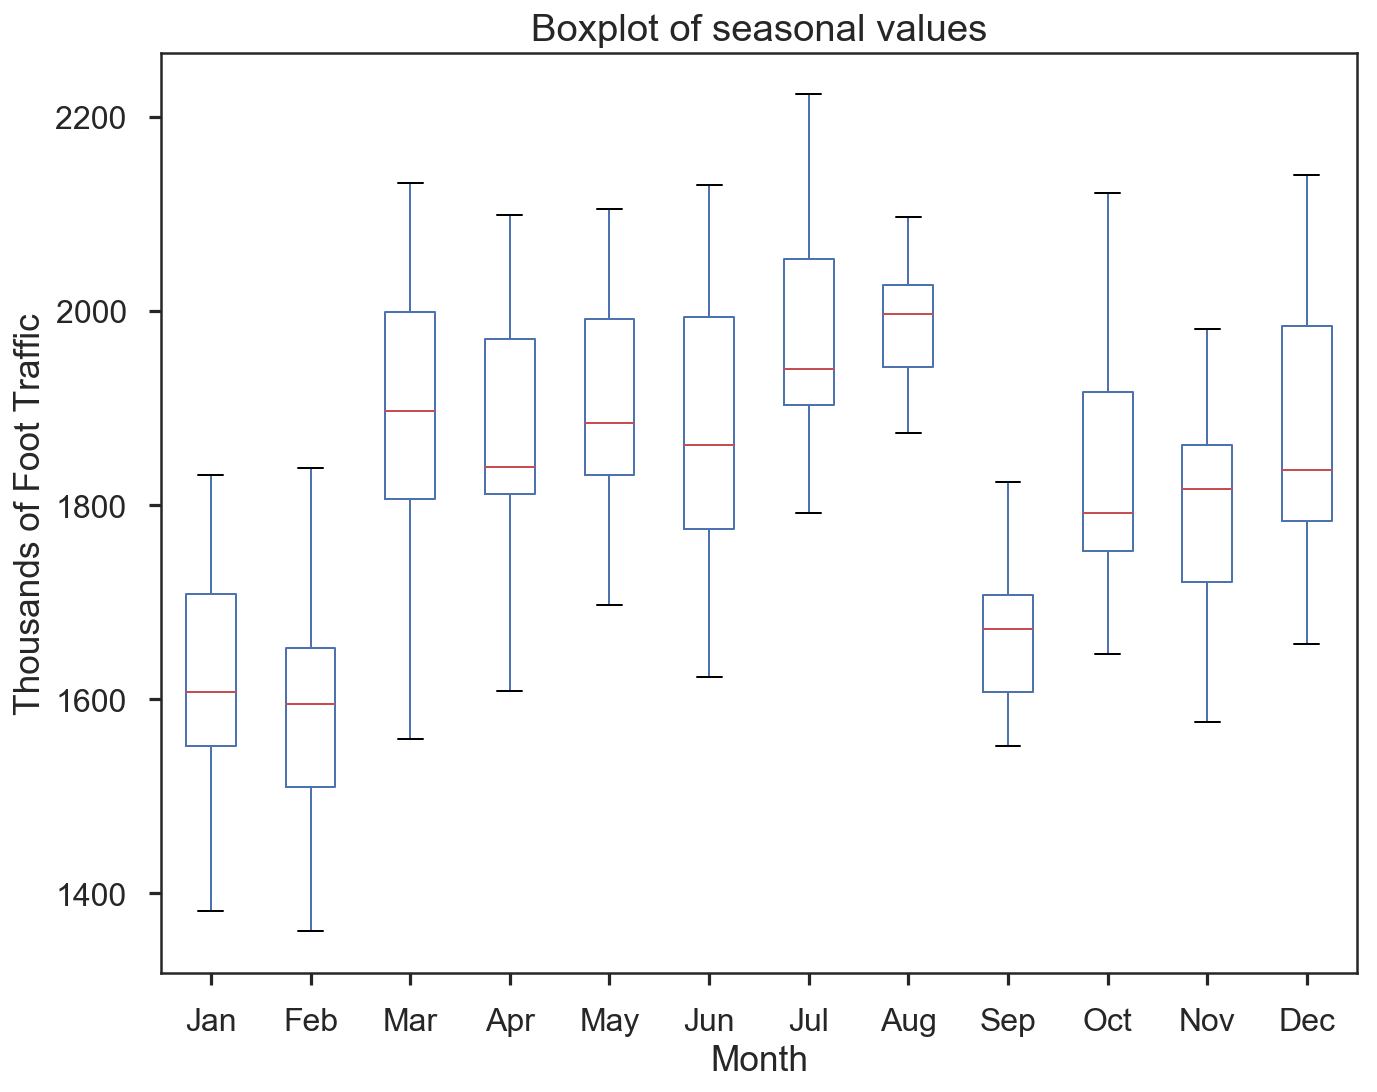

In [12]:
ts['Month'] = ts.index.strftime('%b')
ts['Year'] = ts.index.year

ts_piv = ts.pivot(index='Year', columns='Month', values="Ridership ('000)")

ts = ts.drop(['Month', 'Year'], axis=1)

# put the months in order
month_names = pd.date_range(start='2016-01-01', periods=12, freq='MS').strftime('%b')
ts_piv = ts_piv.reindex(columns=month_names)

# plot it
fig, ax = plt.subplots(figsize=(10, 8))
ts_piv.plot(ax=ax, kind='box');

ax.set_xlabel('Month');
ax.set_ylabel('Thousands of Foot Traffic');
ax.set_title('Boxplot of seasonal values');
ax.xaxis.set_ticks_position('bottom')
fig.tight_layout();

<div class="alert alert-info">
 $Differencing$
 </div>

In [13]:
# Take log of the series
ts['lnts'] = np.log(ts_train["Ridership ('000)"])
print(ts['lnts'].head(),"\n")
print(ts['lnts'].shape,"\n")

# Take first difference of the series
#ts_ln_diff = ts['lnts'].diff() - ts['lnts'].shift()
ts_ln_diff = ts['lnts'].diff()
ts_ln_diff = ts_ln_diff.dropna()
print(ts_ln_diff.head(),"\n")
print(ts_ln_diff.shape,"\n")

Month
1991-01-01   7.44362
1991-02-01   7.39054
1991-03-01   7.58717
1991-04-01   7.50200
1991-05-01   7.58831
Name: lnts, dtype: float64 

(159,) 

Month
1991-02-01   -0.05307
1991-03-01    0.19662
1991-04-01   -0.08516
1991-05-01    0.08630
1991-06-01   -0.05871
Name: lnts, dtype: float64 

(151,) 



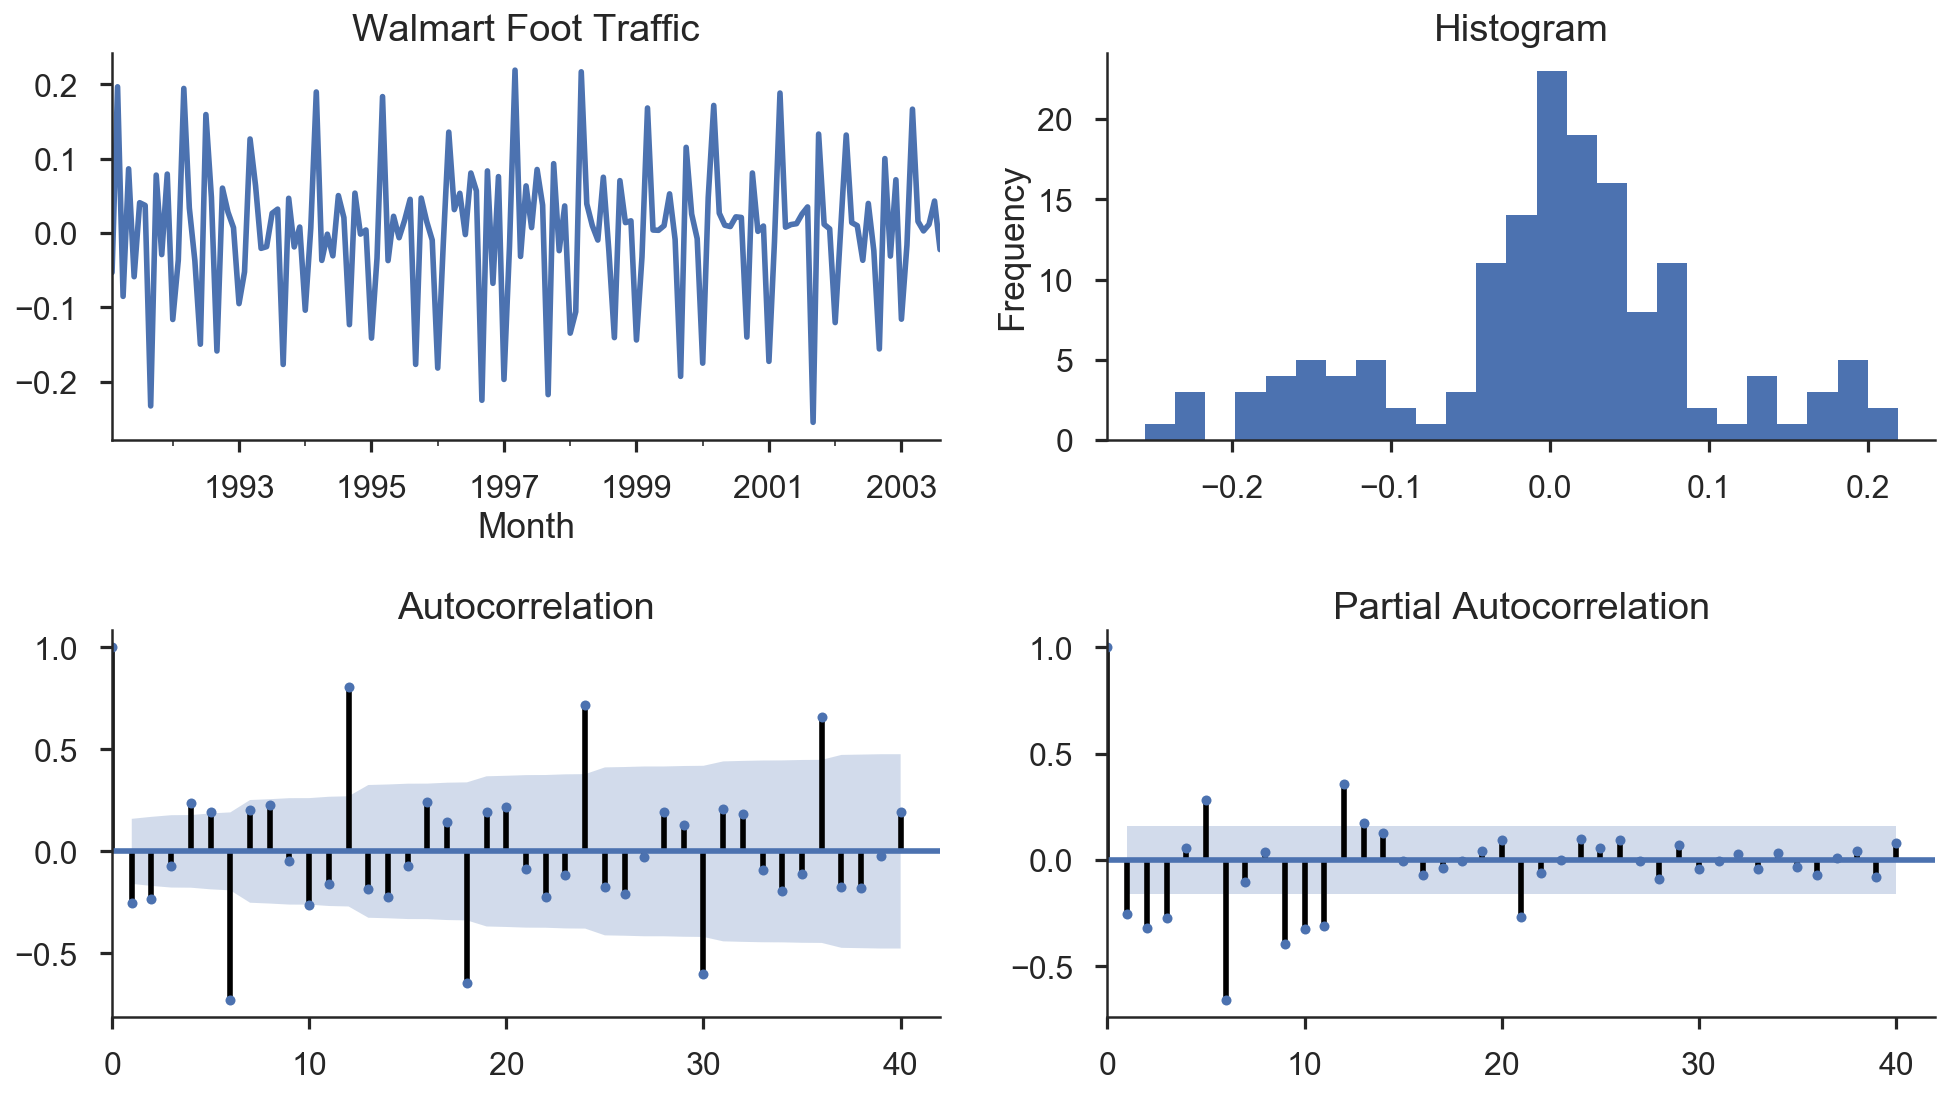

In [14]:
tsplot(ts_ln_diff, lags=40, title='Walmart Foot Traffic', figsize=(14, 8));

<div class="alert alert-success">
**Test for Heteroskedasticity: ** $Breakvar$

**Normality: ** $Jarque-Bera$

**Serial Correlation: ** $Ljung-Box$

</div>

In [48]:
def model_resid_stats(model_results,
                      het_method='breakvar',
                      norm_method='jarquebera',
                      sercor_method='ljungbox',
                      verbose=True,
                      ):
    '''More information about the statistics under the ARIMA parameters table, tests of standardized residuals:
    
    Test of heteroskedasticity
    http://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAXResults.test_heteroskedasticity.html#statsmodels.tsa.statespace.sarimax.SARIMAXResults.test_heteroskedasticity

    Test of normality (Default: Jarque-Bera)
    http://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAXResults.test_normality.html#statsmodels.tsa.statespace.sarimax.SARIMAXResults.test_normality

    Test of serial correlation (Default: Ljung-Box)
    http://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAXResults.test_serial_correlation.html
    '''
    # Re-run the ARIMA model statistical tests, and more. To be used when selecting viable models.
    (het_stat, het_p) = model_results.test_heteroskedasticity(het_method)[0]
    norm_stat, norm_p, skew, kurtosis = model_results.test_normality(norm_method)[0]
    sercor_stat, sercor_p = model_results.test_serial_correlation(method=sercor_method)[0]
    sercor_stat = sercor_stat[-1] # last number for the largest lag
    sercor_p = sercor_p[-1] # last number for the largest lag

    # Run Durbin-Watson test on the standardized residuals.
    # The statistic is approximately equal to 2*(1-r), where r is the sample autocorrelation of the residuals.
    # Thus, for r == 0, indicating no serial correlation, the test statistic equals 2.
    # This statistic will always be between 0 and 4. The closer to 0 the statistic,
    # the more evidence for positive serial correlation. The closer to 4,
    # the more evidence for negative serial correlation.
    # Essentially, below 1 or above 3 is bad.
    dw_stat = sm.stats.stattools.durbin_watson(model_results.filter_results.standardized_forecasts_error[0, model_results.loglikelihood_burn:])

    # check whether roots are outside the unit circle (we want them to be);
    # will be True when AR is not used (i.e., AR order = 0)
    arroots_outside_unit_circle = np.all(np.abs(model_results.arroots) > 1)
    # will be True when MA is not used (i.e., MA order = 0)
    maroots_outside_unit_circle = np.all(np.abs(model_results.maroots) > 1)
    
    if verbose:
        print('Test heteroskedasticity of residuals ({}): stat={:.3f}, p={:.3f}'.format(het_method, het_stat, het_p));
        print('\nTest normality of residuals ({}): stat={:.3f}, p={:.3f}'.format(norm_method, norm_stat, norm_p));
        print('\nTest serial correlation of residuals ({}): stat={:.3f}, p={:.3f}'.format(sercor_method, sercor_stat, sercor_p));
        print('\nDurbin-Watson test on residuals: d={:.2f}\n\t(NB: 2 means no serial correlation, 0=pos, 4=neg)'.format(dw_stat))
        print('\nTest for all AR roots outside unit circle (>1): {}'.format(arroots_outside_unit_circle))
        print('\nTest for all MA roots outside unit circle (>1): {}'.format(maroots_outside_unit_circle))
    
    stat = {'het_method': het_method,
            'het_stat': f"{het_stat:.4f}",
            'het_p': f"{het_p:.4f}",
            'norm_method': norm_method,
            'norm_stat': f"{norm_stat:.4f}",
            'norm_p': f"{norm_p:.4f}",
            'skew': f"{skew:.4f}",
            'kurtosis': f"{kurtosis:.4f}",
            'sercor_method': sercor_method,
            'sercor_stat': f"{sercor_stat:.4f}",
            'sercor_p': f"{sercor_p:.4f}",
            'dw_stat': f"{dw_stat:.4f}",
            'arroots_outside_unit_circle': arroots_outside_unit_circle,
            'maroots_outside_unit_circle': maroots_outside_unit_circle,
            }
    return stat

$Breakvar$: test for heteroskedasticity of standardized residuals. The null hypothesis is of no heteroskedasticity. 
Two-sided: Null hypothesis is that the variance is not changing throughout the sample. 
Both that the sum-of-squares in the earlier subsample is not greater than the sum-of-squares in the 
later subsample and that the sum-of-squares in the later subsample is not greater than the sum-of-squares in the earlier subsample.

$Jarque–Bera$: test is a goodness-of-fit test of whether sample data have the skewness and kurtosis matching a normal distribution. Note that this test only works for a large enough number of data samples (>2000). The null hypothesis for the test is that the data is normally distributed; the alternate hypothesis is that the data does not come from a normal distribution.

$Ljung$-$Box$: test for no serial correlation of standardized residuals. Null hypothesis is no serial correlation.

$Durbin-Watson$: test on the standardized residuals.
The statistic is approximately equal to 2*(1-r), where r is the sample autocorrelation of the residuals.
Thus, for r == 0, indicating no serial correlation, the test statistic equals 2.
This statistic will always be between 0 and 4. The closer to 0 the statistic, the more evidence for positive serial    correlation. The closer to 4,
the more evidence for negative serial correlation.
Essentially, below 1 or above 3 is bad.

$AR$ & $MA$ $Roots$: must be outside the unit circle.

<div class = "alert alert-info">
$Grid$ $Search$
</div>

In [16]:
def model_gridsearch(ts,
                     p_min,
                     d_min,
                     q_min,
                     p_max,
                     d_max,
                     q_max,
                     sP_min,
                     sD_min,
                     sQ_min,
                     sP_max,
                     sD_max,
                     sQ_max,
                     trends,
                     s=None,
                     enforce_stationarity=True,
                     enforce_invertibility=True,
                     simple_differencing=False,
                     plot_diagnostics=False,
                     verbose=False,
                     filter_warnings=True,
                    ):
    '''Run grid search of SARIMAX models and save results.
    '''
    
    cols = ['p', 'd', 'q', 'sP', 'sD', 'sQ', 's', 'trend',
            'enforce_stationarity', 'enforce_invertibility', 'simple_differencing',
            'aic', 'bic',
            'het_p', 'norm_p', 'sercor_p', 'dw_stat',
            'arroots_gt_1', 'maroots_gt_1',
            'datetime_run']

    # Initialize a DataFrame to store the results
    df_results = pd.DataFrame(columns=cols)

    # # Initialize a DataFrame to store the results
    # results_bic = pd.DataFrame(index=['AR{}'.format(i) for i in range(p_min,p_max+1)],
    #                            columns=['MA{}'.format(i) for i in range(q_min,q_max+1)])

    mod_num=0
    for trend,p,d,q,sP,sD,sQ in itertools.product(trends,
                                                  range(p_min,p_max+1),
                                                  range(d_min,d_max+1),
                                                  range(q_min,q_max+1),
                                                  range(sP_min,sP_max+1),
                                                  range(sD_min,sD_max+1),
                                                  range(sQ_min,sQ_max+1),
                                                  ):
        # initialize to store results for this parameter set
        this_model = pd.DataFrame(index=[mod_num], columns=cols)

        if p==0 and d==0 and q==0:
            continue

        try:
            model = sm.tsa.SARIMAX(ts,
                                   trend=trend,
                                   order=(p, d, q),
                                   seasonal_order=(sP, sD, sQ, s),
                                   enforce_stationarity=enforce_stationarity,
                                   enforce_invertibility=enforce_invertibility,
                                   simple_differencing=simple_differencing,
                                  )
            
            if filter_warnings is True:
                with warnings.catch_warnings():
                    warnings.filterwarnings("ignore")
                    model_results = model.fit(disp=0)
            else:
                model_results = model.fit()

            if verbose:
                print(model_results.summary())

            if plot_diagnostics:
                model_results.plot_diagnostics();

            stat = model_resid_stats(model_results,
                                     verbose=verbose)

            this_model.loc[mod_num, 'p'] = p
            this_model.loc[mod_num, 'd'] = d
            this_model.loc[mod_num, 'q'] = q
            this_model.loc[mod_num, 'sP'] = sP
            this_model.loc[mod_num, 'sD'] = sD
            this_model.loc[mod_num, 'sQ'] = sQ
            this_model.loc[mod_num, 's'] = s
            this_model.loc[mod_num, 'trend'] = trend
            this_model.loc[mod_num, 'enforce_stationarity'] = enforce_stationarity
            this_model.loc[mod_num, 'enforce_invertibility'] = enforce_invertibility
            this_model.loc[mod_num, 'simple_differencing'] = simple_differencing

            this_model.loc[mod_num, 'aic'] = model_results.aic
            this_model.loc[mod_num, 'bic'] = model_results.bic

            # this_model.loc[mod_num, 'het_method'] = stat['het_method']
            # this_model.loc[mod_num, 'het_stat'] = stat['het_stat']
            this_model.loc[mod_num, 'het_p'] = stat['het_p']
            # this_model.loc[mod_num, 'norm_method'] = stat['norm_method']
            # this_model.loc[mod_num, 'norm_stat'] = stat['norm_stat']
            this_model.loc[mod_num, 'norm_p'] = stat['norm_p']
            # this_model.loc[mod_num, 'skew'] = stat['skew']
            # this_model.loc[mod_num, 'kurtosis'] = stat['kurtosis']
            # this_model.loc[mod_num, 'sercor_method'] = stat['sercor_method']
            # this_model.loc[mod_num, 'sercor_stat'] = stat['sercor_stat']
            this_model.loc[mod_num, 'sercor_p'] = stat['sercor_p']
            this_model.loc[mod_num, 'dw_stat'] = stat['dw_stat']
            this_model.loc[mod_num, 'arroots_gt_1'] = stat['arroots_outside_unit_circle']
            this_model.loc[mod_num, 'maroots_gt_1'] = stat['maroots_outside_unit_circle']

            this_model.loc[mod_num, 'datetime_run'] = pd.to_datetime('today').strftime('%Y-%m-%d %H:%M:%S')

            df_results = df_results.append(this_model)
            mod_num+=1
        except:
            continue
    return df_results

<div class = "alert alert-danger">
$Select$ $ARIMA$ $&$ $Seasonal$ $Paramters$ $for$ $Grid$ $Search$
</div>

In [17]:
# run model grid search
#ARIMA parameters

p_min = 0
d_min = 0
q_min = 0
p_max = 2
d_max = 1
q_max = 2

#Seasonal parameters

sP_min = 0
sD_min = 0
sQ_min = 0
sP_max = 1
sD_max = 1
sQ_max = 1

s=12

# trends=['n', 'c']
trends=['n']

enforce_stationarity=True
enforce_invertibility=True
simple_differencing=False

plot_diagnostics=False

verbose=False

df_results = model_gridsearch(ts_ln_diff,
                              p_min,
                              d_min,
                              q_min,
                              p_max,
                              d_max,
                              q_max,
                              sP_min,
                              sD_min,
                              sQ_min,
                              sP_max,
                              sD_max,
                              sQ_max,
                              trends,
                              s=s,
                              enforce_stationarity=enforce_stationarity,
                              enforce_invertibility=enforce_invertibility,
                              simple_differencing=simple_differencing,
                              plot_diagnostics=plot_diagnostics,
                              verbose=verbose,
                              )

<div class = "alert alert-info">
$Run$ $Grid$ $Search$
<div>

In [18]:
# choose a model

df_results.sort_values(by='bic').head(10)

p  d  q sP sD sQ   s trend enforce_stationarity enforce_invertibility  \
5    0  0  1  1  0  1  12     n                 True                  True   
13   0  0  2  1  0  1  12     n                 True                  True   
35   1  0  0  1  0  1  12     n                 True                  True   
47   1  0  2  1  0  1  12     n                 True                  True   
83   2  0  1  1  0  1  12     n                 True                  True   
75   2  0  0  1  0  1  12     n                 True                  True   
3    0  0  1  0  1  1  12     n                 True                  True   
107  2  1  2  1  0  1  12     n                 True                  True   
39   1  0  1  0  1  1  12     n                 True                  True   
33   1  0  0  0  1  1  12     n                 True                  True   

    simple_differencing        aic        bic   het_p  norm_p sercor_p  \
5                 False -545.23985 -533.17073 0.02754 0.64648  0.80400   
13                False -545.00006 -529.91366 0.03437 0.68927  0.81789   
35                False -539.82836 -527.75924 0.02706 0.60703  0.65646   
47                False -545.66840 -527.56472 0.03972 0.53000  0.91802   
83                False -545.61739 -527.51371 0.01781 0.38172  0.93083   
75                False -541.91821 -526.83181 0.02075 0.68582  0.80690   
3                 False -520.89102 -511.83918 0.05231 0.92449  0.98053   
107               False -530.69138 -509.57042 0.01124 0.60661  0.86927   
39                False -521.49369 -509.42457 0.06987 0.77462  0.99363   
33                False -516.93250 -507.88066 0.04515 0.90395  0.97454   

    dw_stat arroots_gt_1 maroots_gt_1         datetime_run  
5   1.92602         True         True  2017-07-29 00:00:00  
13  1.97948         True         True  2017-07-29 00:00:00  
35  2.10868         True         True  2017-07-29 00:00:00  
47  2.05754         True         True  2017-07-29 00:00:00  
83  2.05069         True         True  2017-07-29 00:00:00  
75  2.02365         True         True  2017-07-29 00:00:00  
3   1.94481         True         True  2017-07-29 00:00:00  
107 2.01882         True        False  2017-07-29 00:00:00  
39  2.06873         True         True  2017-07-29 00:00:00  
33  2.09404         True         True  2017-07-29 00:00:00

$Breakvar$: (**het**) test for heteroskedasticity of standardized residuals. The null hypothesis is of no heteroskedasticity. 
Two-sided: Null hypothesis is that the variance is not changing throughout the sample. 
Both that the sum-of-squares in the earlier subsample is not greater than the sum-of-squares in the 
later subsample and that the sum-of-squares in the later subsample is not greater than the sum-of-squares in the earlier subsample.

$Jarque–Bera$: (**norm**) test is a goodness-of-fit test of whether sample data have the skewness and kurtosis matching a normal distribution. Note that this test only works for a large enough number of data samples (>2000). The null hypothesis for the test is that the data is normally distributed; the alternate hypothesis is that the data does not come from a normal distribution.

$Ljung$-$Box$: (**sercor**) test for no serial correlation of standardized residuals. Null hypothesis is no serial correlation.  **H0**: The data are independently distributed (i.e. the correlations in the population from which the sample is taken are 0, so that any observed correlations in the data result from randomness of the sampling process).
**Ha**: The data are not independently distributed; they exhibit serial correlation.

$Durbin-Watson$: test on the standardized residuals.
The statistic is approximately equal to 2*(1-r), where r is the sample autocorrelation of the residuals.
Thus, for r == 0, indicating no serial correlation, the test statistic equals 2.
This statistic will always be between 0 and 4. The closer to 0 the statistic, the more evidence for positive serial    correlation. The closer to 4,
the more evidence for negative serial correlation.
Essentially, below 1 or above 3 is bad.

$AR$ & $MA$ $Roots$: must be outside the unit circle.

<div class = "alert alert-info">
$Seasonal$ $ARIMA$ $Model$ $for$ $Forecasting$
</div>

In [21]:
# Selected Grid Search Model
mod = sm.tsa.statespace.SARIMAX(ts_ln_diff, order=(0,0,2), seasonal_order=(1,0,1,12), simple_differencing=True)
sarima_fit1 = mod.fit()
print(sarima_fit1.summary())

                                 Statespace Model Results                                 
Dep. Variable:                               lnts   No. Observations:                  151
Model:             SARIMAX(0, 0, 2)x(1, 0, 1, 12)   Log Likelihood                 277.500
Date:                            Sat, 29 Jul 2017   AIC                           -545.000
Time:                                    19:31:24   BIC                           -529.914
Sample:                                02-01-1991   HQIC                          -538.871
                                     - 08-01-2003                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4299      0.081     -5.320      0.000      -0.588      -0.272
ma.L2         -0.1315      0.078   

<div class = "alert alert-info">
$ARIMA$ $Model$ $for$ $Forecasting$
</div>

In [20]:
#Model Estimation

# Fit the model
arima200 = sm.tsa.SARIMAX(ts_train, order=(2,0,0))
model_results = arima200.fit()
model_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:       Ridership ('000)   No. Observations:                  152
Model:               SARIMAX(2, 0, 0)   Log Likelihood                -990.540
Date:                Sat, 29 Jul 2017   AIC                           1987.079
Time:                        19:30:52   BIC                           1996.151
Sample:                    01-01-1991   HQIC                          1990.764
                         - 08-01-2003                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7420      0.118      6.288      0.000       0.511       0.973
ar.L2          0.2552      0.118      2.159      0.031       0.024       0.487
sigma2      2.591e+04   3060.082      8.468      0.000    1.99e+04    3.19e+04
===================================================================================
Ljung-Box (Q):                      723.76   Jarque-Bera (JB):                 6.85
Prob(Q):                              0.00   Prob(JB):                         0.03
Heteroskedasticity (H):               1.04   Skew:                            -0.49
Prob(H) (two-sided):                  0.90   Kurtosis:                         3.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<div class = "alert alert-info">
$Model$ $Disgnostic$
</div>

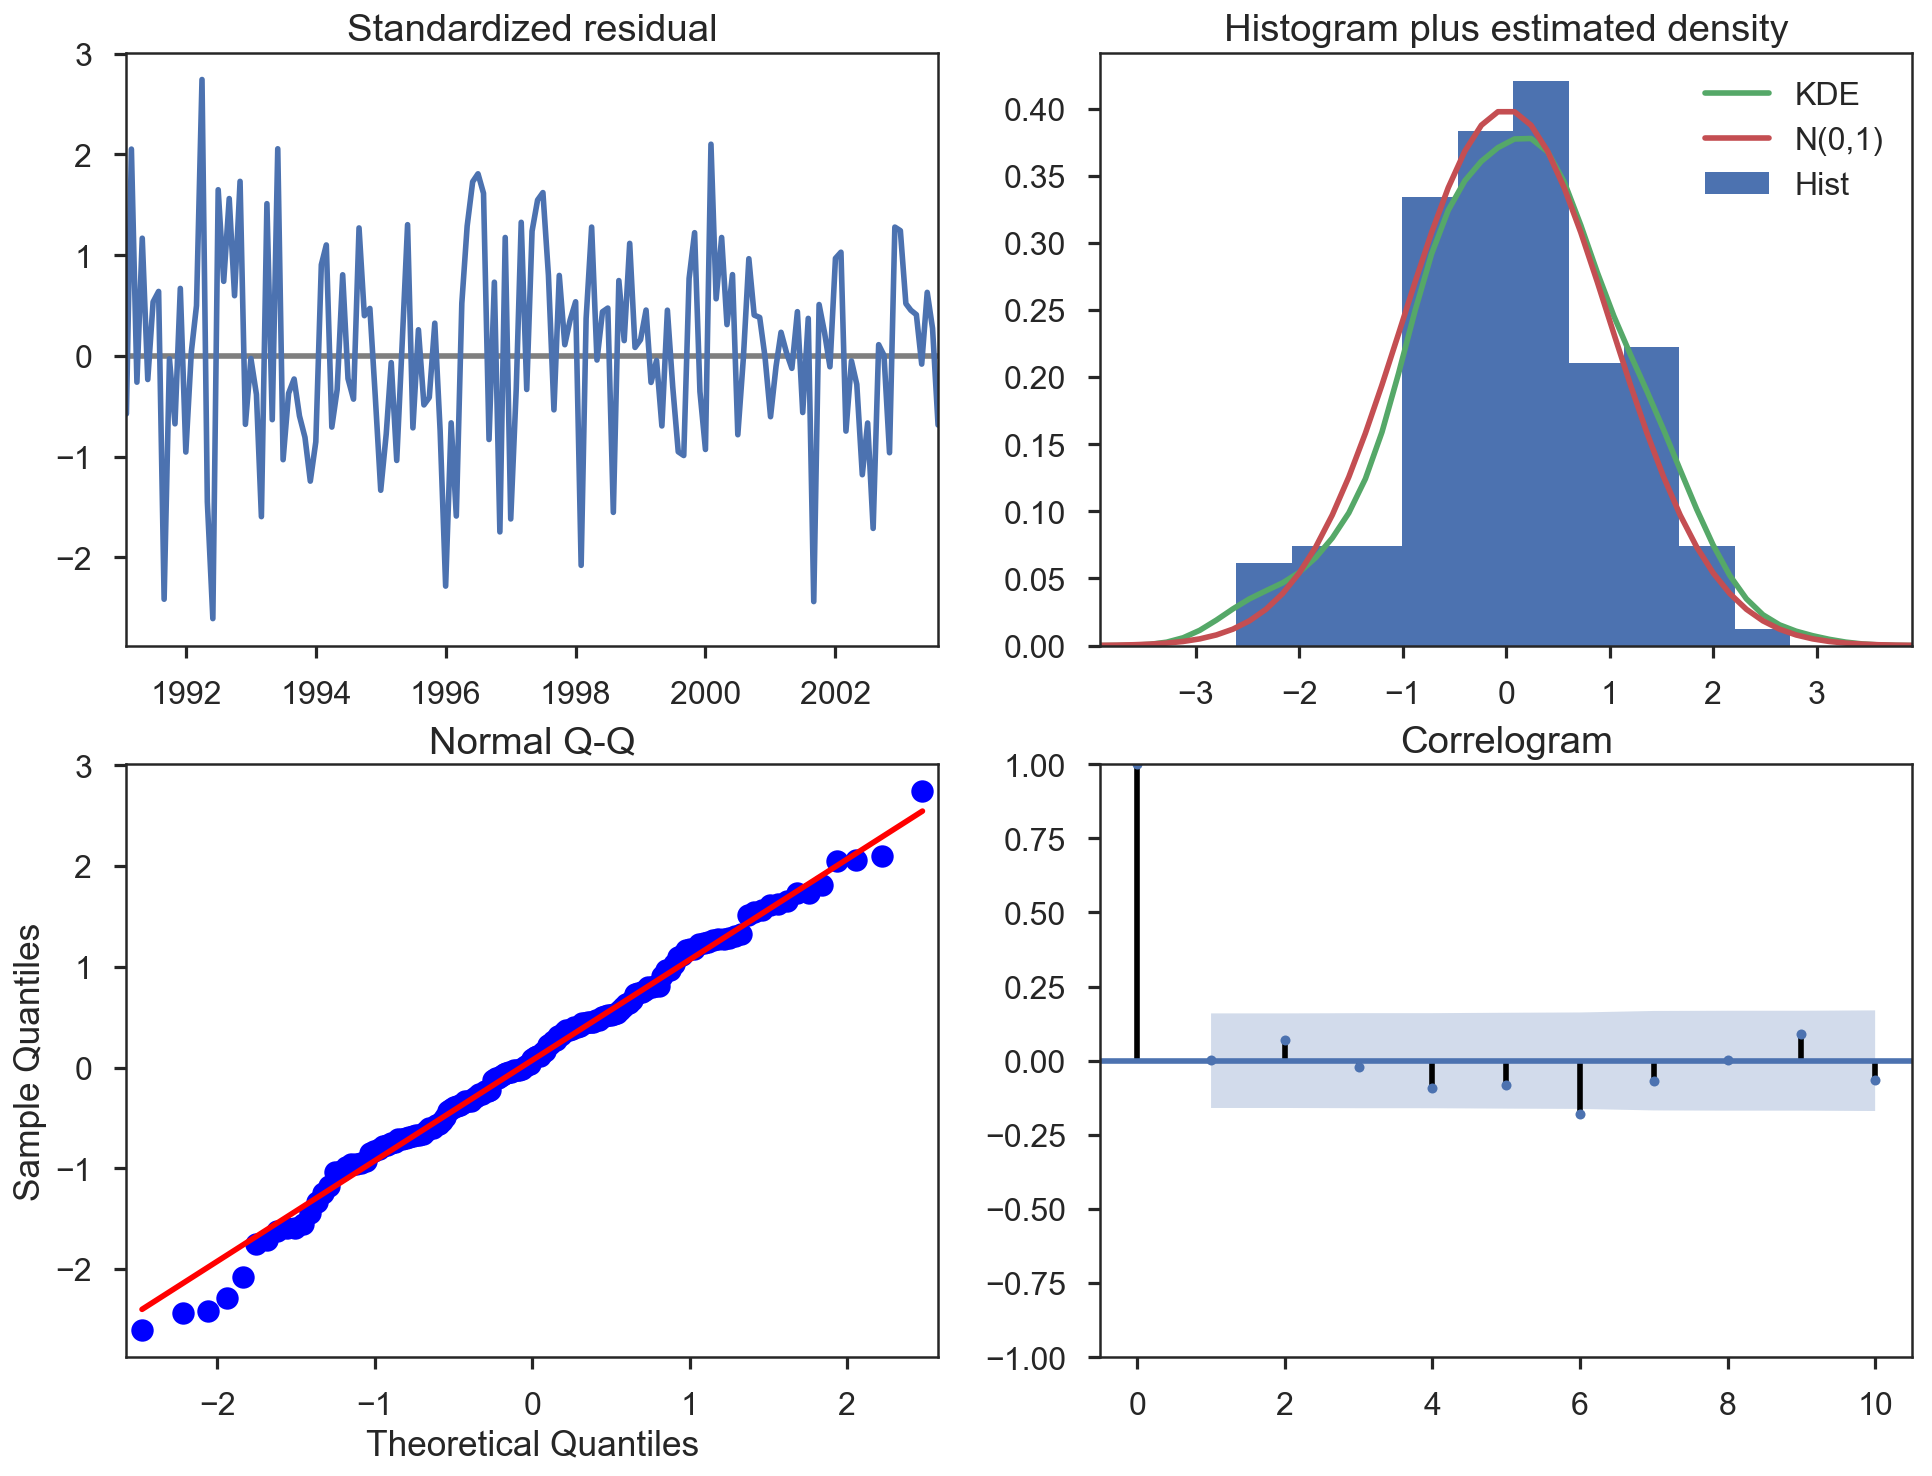

In [22]:
# Model Diagnostic

sarima_fit1.plot_diagnostics(figsize=(16, 12));

<div class = "alert alert-success">

$Transform$ $Test$ $Set$

</div>

In [27]:
# Take log of the test series
ts_test['lnts'] = np.log(ts_test["Ridership ('000)"])
print(ts_test['lnts'].head(),"\n")
print(ts_test['lnts'].shape,"\n")

# Take first difference of the series
#ts_ln_diff = ts['lnts'].diff() - ts['lnts'].shift()
test_ln_diff = ts_test['lnts'].diff()
test_ln_diff = test_ln_diff.dropna()
print(test_ln_diff.head(),"\n")
print(test_ln_diff.shape,"\n")


Month
2003-09-01   7.56600
2003-10-01   7.65986
2003-11-01   7.63822
2003-12-01   7.66888
2004-01-01   7.51289
Name: lnts, dtype: float64 

(7,) 

Month
2003-10-01    0.09386
2003-11-01   -0.02164
2003-12-01    0.03065
2004-01-01   -0.15598
2004-02-01    0.00354
Name: lnts, dtype: float64 

(6,) 



<div class = "alert alert-success">

$Model$ $Performance$ $Evaluation$ (in-sample fit)

</div>

##### Adjust time if needed for model
```bash
start=pred_begin.strftime('%Y-%m-%d %H:%M:%S')

start=pred_begin.strftime('%Y-%m-%d')
```

<div class = "alert alert-danger">

$Seasonal$ $Model$ 

</div>

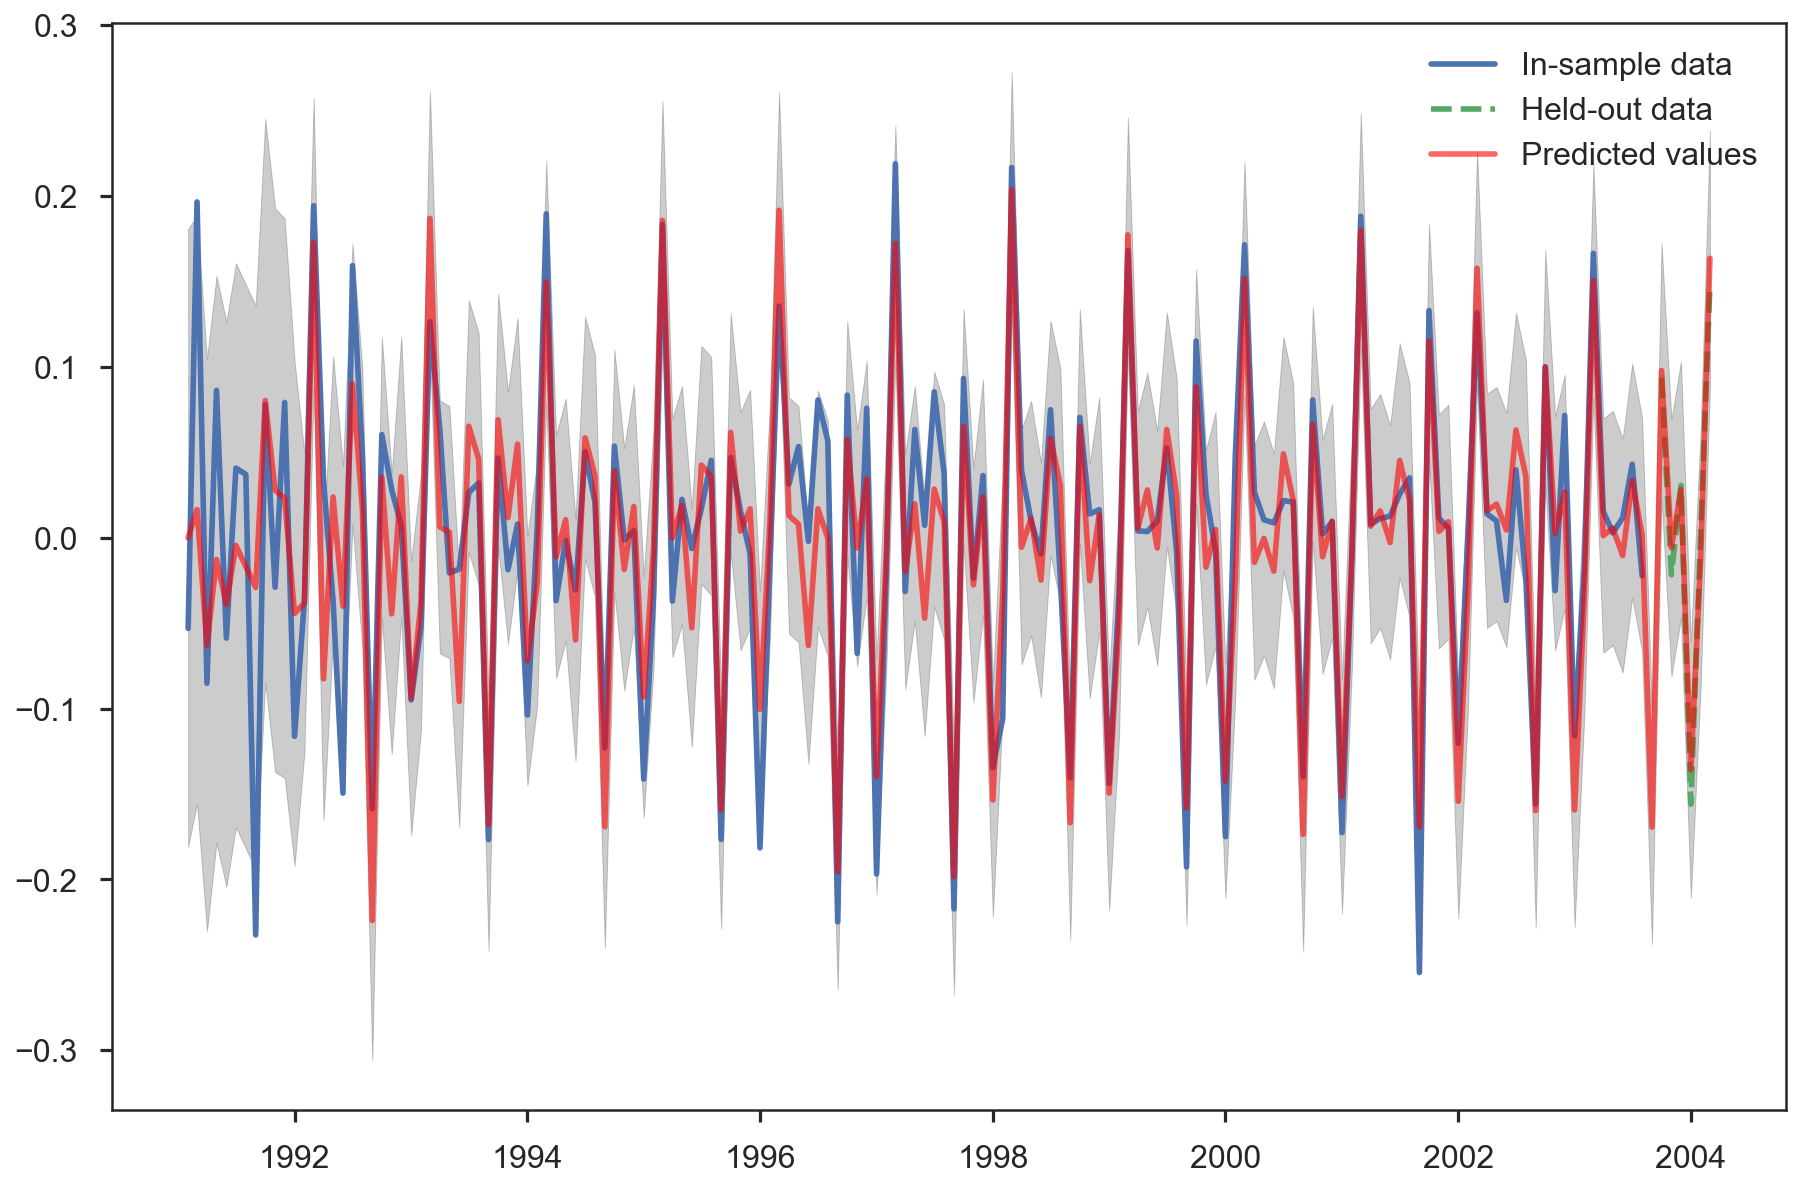

In [47]:
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(15, 10))
    
ax1.plot(ts_ln_diff, label='In-sample data', linestyle='-')
# subtract 1 only to connect it to previous point in the graph
ax1.plot(test_ln_diff, label='Held-out data', linestyle='--')

# yes DatetimeIndex
pred_begin = ts_ln_diff.index[sarima_fit1.loglikelihood_burn]
pred_end = test_ln_diff.index[-1]
pred = sarima_fit1.get_prediction(start=pred_begin.strftime('%Y-%m-%d'),
                                    end=pred_end.strftime('%Y-%m-%d'))
pred_mean = pred.predicted_mean
pred_ci = pred.conf_int(alpha=0.05)

ax1.plot(pred_mean, 'r', alpha=.6, label='Predicted values')
ax1.fill_between(pred_ci.index,
                 pred_ci.iloc[:, 0],
                 pred_ci.iloc[:, 1], color='k', alpha=.2)

ax1.legend(loc='best');

<div class = "alert alert-danger">

$ARIMA$ $Model$ 

</div>

In [ ]:
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))
    
ax1.plot(ts_train, label='In-sample data', linestyle='-')
# subtract 1 only to connect it to previous point in the graph
ax1.plot(ts_test, label='Held-out data', linestyle='--')

# yes DatetimeIndex
pred_begin = ts_train.index[model_results.loglikelihood_burn]
pred_end = ts_test.index[-1]
pred = model_results.get_prediction(start=pred_begin.strftime('%Y-%m-%d %H:%M:%S'),
                                    end=pred_end.strftime('%Y-%m-%d %H:%M:%S'))
pred_mean = pred.predicted_mean
pred_ci = pred.conf_int(alpha=0.05)

ax1.plot(pred_mean, 'r', alpha=.6, label='Predicted values')
ax1.fill_between(pred_ci.index,
                 pred_ci.iloc[:, 0],
                 pred_ci.iloc[:, 1], color='k', alpha=.2)

ax1.legend(loc='best');

<div class = "alert alert-success">

$Root$ $Mean$ $Square$ $Error$, $Mean$ $Absolute$ $Percent$ $Error$, $Mean$ $Absolute$ $Scaled$ $Error$
</div>

In [30]:
def get_rmse(y, y_hat):
    '''Root Mean Square Error
    https://en.wikipedia.org/wiki/Root-mean-square_deviation
    '''
    mse = np.mean((y - y_hat)**2)
    return np.sqrt(mse)

def get_mape(y, y_hat):
    '''Mean Absolute Percent Error
    https://en.wikipedia.org/wiki/Mean_absolute_percentage_error
    '''
    perc_err = (100*(y - y_hat))/y
    return np.mean(abs(perc_err))

def get_mase(y, y_hat):
    '''Mean Absolute Scaled Error
    https://en.wikipedia.org/wiki/Mean_absolute_scaled_error
    '''
    abs_err = abs(y - y_hat)
    dsum=sum(abs(y[1:] - y_hat[1:]))
    t = len(y)
    denom = (1/(t - 1))* dsum
    return np.mean(abs_err/denom)

<div class = "alert alert-success">
$Training$ $Set$ $Metrics$
</div>

In [49]:
rmse = get_rmse(ts_ln_diff, pred_mean.loc[ts_ln_diff.index])
print(f"Root Mean Square Error: {rmse:.4f}")

mape = get_mape(ts_ln_diff, pred_mean.loc[ts_ln_diff.index])
print(f"Mean Absolute Percent Error: {mape:.4f}")

mase = get_mase(ts_ln_diff, pred_mean.loc[ts_ln_diff.index])
print(f"Mean Absolute Scaled Error: {mase:.4f} ")

Root Mean Square Error: 0.0438
Mean Absolute Percent Error: 135.7131
Mean Absolute Scaled Error: 1.0043 


<div class = "alert alert-success">
$Test$ $Set$ $Metrics$
</div>

In [50]:
rmse = get_rmse(test_ln_diff, pred_mean.loc[test_ln_diff.index])
print(f"Root Mean Square Error: {rmse:.4f}")

mape = get_mape(test_ln_diff, pred_mean.loc[test_ln_diff.index])
print(f"Mean Absolute Percent Error: {mape:.4f}")

mase = get_mase(test_ln_diff, pred_mean.loc[test_ln_diff.index])
print(f"Mean Absolute Scaled Error: {mase:.4f}")

Root Mean Square Error: 0.0137
Mean Absolute Percent Error: 88.3531
Mean Absolute Scaled Error: 0.8826


In [45]:
report = model_resid_stats(sarima_fit1,
                      het_method='breakvar',
                      norm_method='jarquebera',
                      sercor_method='ljungbox',
                      verbose=True,
                      )
report

Test heteroskedasticity of residuals (breakvar): stat=0.546, p=0.034

Test normality of residuals (jarquebera): stat=0.744, p=0.689

Test serial correlation of residuals (ljungbox): stat=31.837, p=0.818

Durbin-Watson test on residuals: d=1.98
	(NB: 2 means no serial correlation, 0=pos, 4=neg)

Test for all AR roots outside unit circle (>1): True

Test for all MA roots outside unit circle (>1): True


{'arroots_outside_unit_circle': True,
 'dw_stat': '1.9795',
 'het_method</b>': 'breakvar',
 'het_p': '0.0344',
 'het_stat': '0.5456',
 'kurtosis': '3.0159',
 'maroots_outside_unit_circle': True,
 'norm_method': 'jarquebera',
 'norm_p': '0.6893',
 'norm_stat': '0.7442',
 'sercor_method': 'ljungbox',
 'sercor_p': '0.8179',
 'sercor_stat': '31.8374',
 'skew': '-0.1718'}